In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2022-11-25 18:53:05.664780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MAIN_PATH = 'facemask/dataset/dataset'
CLASSES = os.listdir(MAIN_PATH)
NUM_CLASSES = 2
HEIGHT,WIDTH = 32,32 # better with fixed size
BATCH_SIZE = 32
SPLIT = 0.2

In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=SPLIT)

train_set = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "training",
    class_mode = "categorical",
    shuffle = True
)

valid_set = train_datagen.flow_from_directory(
    MAIN_PATH,
    target_size = (HEIGHT,WIDTH),
    batch_size = BATCH_SIZE,
    subset = "validation",
    class_mode = "categorical",
    shuffle = True
)


Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


In [4]:
# ResNet reference from https://blog.csdn.net/weixin_44815085/article/details/104348749
        
class Basic_Block(keras.layers.Layer):
    def __init__(self, out_channels, strides=1):
        super(Basic_Block, self).__init__()        
        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        if strides != 1:
            self.downsample = tf.keras.models.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=strides))
        else:
            self.downsample = lambda x:x

    def call(self, x, training=None):
        x_identity = self.downsample(x)
        y = self.conv1(x)
        y = self.bn1(y,training=training)
        y = self.relu(y)

        y = self.conv2(y)
        y = self.bn2(y,training=training)
        
        y = keras.layers.add([y, x_identity])
        y = tf.nn.relu(y)

        return y
    
class Res_Block(keras.layers.Layer):
    def __init__(self, out_channel, layer_dimension, strides=1):
        super(Res_Block, self).__init__() 
        self.res_block = tf.keras.models.Sequential()
        self.res_block.add(Basic_Block(out_channel, strides))
        for _ in range(1, layer_dimension):
            self.res_block.add(Basic_Block(out_channel, strides=1))
    def call(self, x):   
        return self.res_block(x)

class ResNet(keras.layers.Layer):
    
    def __init__(self, layer_dimensions, num_classes=2):
        super(ResNet, self).__init__()

        self.stem = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, strides=1),
                                                 tf.keras.layers.BatchNormalization(),
                                                 tf.keras.layers.Activation('relu'),
                                                 tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding='same')
                                                ])

        self.layer1 = Res_Block(64,  layer_dimensions[0])
        self.layer2 = Res_Block(128, layer_dimensions[1], strides=2)
        self.layer3 = Res_Block(256, layer_dimensions[2], strides=2)
        self.layer4 = Res_Block(512, layer_dimensions[3], strides=2)
        
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=None):

        Y = self.stem(x, training=training)
        
        Y = self.layer1(Y,training=training)
        Y = self.layer2(Y,training=training)
        Y = self.layer3(Y,training=training)
        Y = self.layer4(Y,training=training)

        Y = self.avgpool(Y)
        
        Y = self.fc(Y)
        
        return Y

In [5]:
class GroupConv(keras.layers.Layer):
    def __init__(self, out_channels, kernel_size, strides, padding, groups, act_norm=True):
        super(GroupConv, self).__init__()
        self.act_norm = act_norm
        self.conv = tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size, strides=strides, padding=padding, groups=groups)
        self.norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
    
    def call(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.relu(self.norm(y))
        return y

class Basic_Block_ResInceNet(keras.layers.Layer):
    def __init__(self, out_channels, strides=1):
        super(Basic_Block_ResInceNet, self).__init__()        
        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=strides, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        layers = []
        for ker in [1,3]:
            layers.append(GroupConv(out_channels, kernel_size=ker, strides=1, padding='same', groups=1, act_norm=True))
        self.layers = layers
        self.bn2 = tf.keras.layers.BatchNormalization()
        if strides != 1:
            self.downsample = tf.keras.models.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=strides))
        else:
            self.downsample = lambda x:x

    def call(self, x, training=None):
        x_identity = self.downsample(x)
        y = self.conv1(x)
        y = self.bn1(y,training=training)
        y = self.relu(y)
        
        z = 0
        for layer in self.layers:
            z += layer(y)
        y = self.bn2(z,training=training)
        
        y = keras.layers.add([y, x_identity])
        y = tf.nn.relu(y)

        return y

class ResInce_Block(keras.layers.Layer):
    def __init__(self, out_channel, layer_dimension, strides=1):
        super(ResInce_Block, self).__init__() 
        self.res_block = tf.keras.models.Sequential()
        self.res_block.add(Basic_Block_ResInceNet(out_channel, strides))
        for _ in range(1, layer_dimension):
            self.res_block.add(Basic_Block_ResInceNet(out_channel, strides=1))
    def call(self, x):   
        return self.res_block(x)    
    
class ResInceNet(keras.layers.Layer):
    
    def __init__(self, layer_dimensions, num_classes=2):
        super(ResInceNet, self).__init__()

        self.stem = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, strides=1),
                                                 tf.keras.layers.BatchNormalization(),
                                                 tf.keras.layers.Activation('relu'),
                                                 tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding='same')
                                                ])

        self.layer1 = ResInce_Block(64,  layer_dimensions[0])
        self.layer2 = ResInce_Block(128, layer_dimensions[1], strides=2)
        self.layer3 = ResInce_Block(256, layer_dimensions[2], strides=2)
        self.layer4 = ResInce_Block(512, layer_dimensions[3], strides=2)
        
        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=None):

        Y = self.stem(x, training=training)
        
        Y = self.layer1(Y,training=training)
        Y = self.layer2(Y,training=training)
        Y = self.layer3(Y,training=training)
        Y = self.layer4(Y,training=training)

        Y = self.avgpool(Y)
        
        Y = self.fc(Y)
        
        return Y

In [6]:
net = tf.keras.models.Sequential(ResNet([2, 2, 2, 2]))

In [7]:
net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),  
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [8]:
net.evaluate(valid_set)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
9/9 [==============================] - 2s 159ms/step - loss: 2.3387 - accuracy: 0.5000


[2.3386921882629395, 0.5]

In [9]:
training_time = time.time()
training_result = net.fit(train_set, 
                          epochs=100, 
                          callbacks = tf.keras.callbacks.EarlyStopping(
                              monitor='val_accuracy',
                              mode='max',
                              patience=10, 
                              verbose=1),
                          validation_data=valid_set)
print("Training time:", time.time()-training_time)

Epoch 1/100
35/35 [==============================] - 34s 829ms/step - loss: 4.7629 - accuracy: 0.5804 - val_loss: 4.3844 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 31s 874ms/step - loss: 4.2646 - accuracy: 0.6362 - val_loss: 4.2364 - val_accuracy: 0.5000
Epoch 3/100
35/35 [==============================] - 34s 982ms/step - loss: 4.1829 - accuracy: 0.6599 - val_loss: 4.2256 - val_accuracy: 0.5000
Epoch 4/100
35/35 [==============================] - 42s 1s/step - loss: 4.2190 - accuracy: 0.6785 - val_loss: 4.2376 - val_accuracy: 0.5000
Epoch 5/100
35/35 [==============================] - 37s 1s/step - loss: 4.0946 - accuracy: 0.6812 - val_loss: 4.2510 - val_accuracy: 0.5000
Epoch 6/100
35/35 [==============================] - 37s 1s/step - loss: 3.9947 - accuracy: 0.6985 - val_loss: 4.2804 - val_accuracy: 0.5000
Epoch 7/100
35/35 [==============================] - 33s 943ms/step - loss: 3.4756 - accuracy: 0.7089 - val_loss: 4.6083 - val_accuracy: 0.5000
E

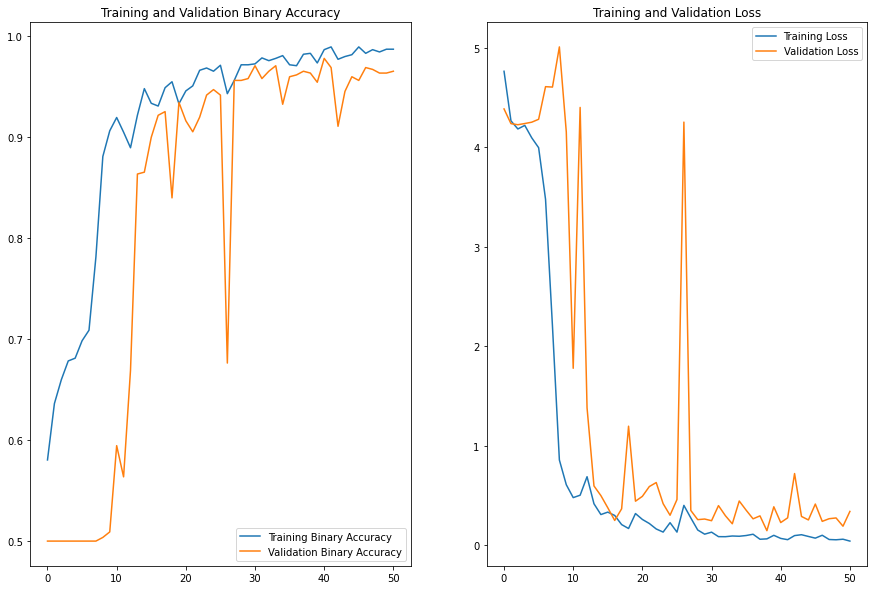

In [10]:
epochs_range = range(len(training_result.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_result.history['accuracy'], label='Training Binary Accuracy')
plt.plot(epochs_range, training_result.history['val_accuracy'], label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_result.history['loss'], label='Training Loss')
plt.plot(epochs_range, training_result.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') 
plt.show()

In [11]:
out = net.predict(test_set[0])

43/43 [==============================] - 12s 259ms/step


In [12]:
net2 = tf.keras.models.Sequential(ResInceNet([1, 1, 1, 1]))

In [13]:
net2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05), 
            loss='binary_crossentropy', # as a binary classificaiton problem
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [14]:
net2.evaluate(valid_set)

9/9 [==============================] - 3s 215ms/step - loss: 4.7971 - accuracy: 0.5000


[4.797133445739746, 0.5]

In [16]:
training_time = time.time()
training_result2 = net2.fit(train_set, 
                          epochs=100, 
                          callbacks = tf.keras.callbacks.EarlyStopping(
                              monitor='val_accuracy',
                              mode='max',
                              patience=10, 
                              verbose=1),
                          validation_data=valid_set)
print("Training time:", time.time()-training_time)

Epoch 1/100
35/35 [==============================] - 19s 547ms/step - loss: 4.2669 - accuracy: 0.6194 - val_loss: 4.4913 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 22s 640ms/step - loss: 4.1897 - accuracy: 0.6490 - val_loss: 4.3120 - val_accuracy: 0.5000
Epoch 3/100
35/35 [==============================] - 23s 660ms/step - loss: 4.1579 - accuracy: 0.6553 - val_loss: 4.2408 - val_accuracy: 0.5000
Epoch 4/100
35/35 [==============================] - 21s 602ms/step - loss: 4.1457 - accuracy: 0.6576 - val_loss: 4.2238 - val_accuracy: 0.5000
Epoch 5/100
35/35 [==============================] - 19s 549ms/step - loss: 4.0636 - accuracy: 0.6730 - val_loss: 4.2053 - val_accuracy: 0.5309
Epoch 6/100
35/35 [==============================] - 20s 581ms/step - loss: 4.0374 - accuracy: 0.6817 - val_loss: 4.2286 - val_accuracy: 0.5018
Epoch 7/100
35/35 [==============================] - 22s 630ms/step - loss: 4.0549 - accuracy: 0.6907 - val_loss: 4.2618 - val_accuracy:

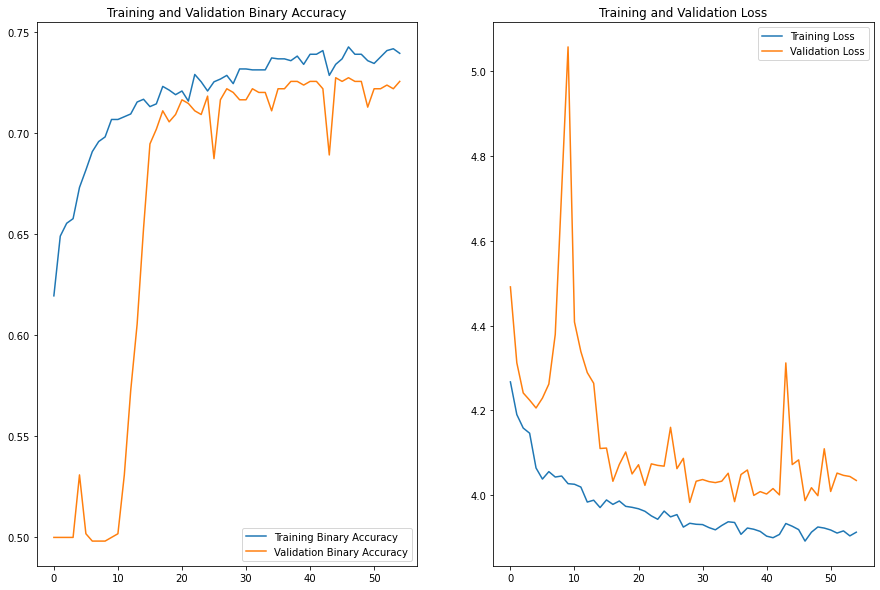

In [20]:
epochs_range = range(len(training_result2.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_result2.history['accuracy'], label='Training Binary Accuracy')
plt.plot(epochs_range, training_result2.history['val_accuracy'], label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_result2.history['loss'], label='Training Loss')
plt.plot(epochs_range, training_result2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') 
plt.show()

In [35]:
net3 = tf.keras.models.Sequential(ResInceNet([2, 2, 2, 2]))

In [36]:
net3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), 
            loss='binary_crossentropy', # as a binary classificaiton problem
            metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [37]:
net3.evaluate(valid_set)

9/9 [==============================] - 3s 173ms/step - loss: 6.9292 - accuracy: 0.4909


[6.929243087768555, 0.4909090995788574]

In [38]:
training_time = time.time()
training_result3 = net3.fit(train_set, 
                            epochs=100, 
                            callbacks = tf.keras.callbacks.EarlyStopping(
                                monitor='val_accuracy',
                                mode='max',
                                patience=20, 
                                verbose=1),
                            validation_data=valid_set)
print("Training time:", time.time()-training_time)

Epoch 1/100
35/35 [==============================] - 42s 987ms/step - loss: 6.0182 - accuracy: 0.5268 - val_loss: 0.7829 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 36s 1s/step - loss: 4.0698 - accuracy: 0.6571 - val_loss: 4.2251 - val_accuracy: 0.4982
Epoch 3/100
35/35 [==============================] - 33s 952ms/step - loss: 2.8142 - accuracy: 0.7816 - val_loss: 4.3235 - val_accuracy: 0.4982
Epoch 4/100
35/35 [==============================] - 33s 941ms/step - loss: 2.4321 - accuracy: 0.8061 - val_loss: 4.3666 - val_accuracy: 0.4982
Epoch 5/100
35/35 [==============================] - 34s 960ms/step - loss: 1.0899 - accuracy: 0.9096 - val_loss: 7.6964 - val_accuracy: 0.4982
Epoch 6/100
35/35 [==============================] - 34s 997ms/step - loss: 0.4285 - accuracy: 0.9596 - val_loss: 7.6964 - val_accuracy: 0.4982
Epoch 7/100
35/35 [==============================] - 32s 916ms/step - loss: 0.3089 - accuracy: 0.9709 - val_loss: 7.6964 - val_accuracy: 0.

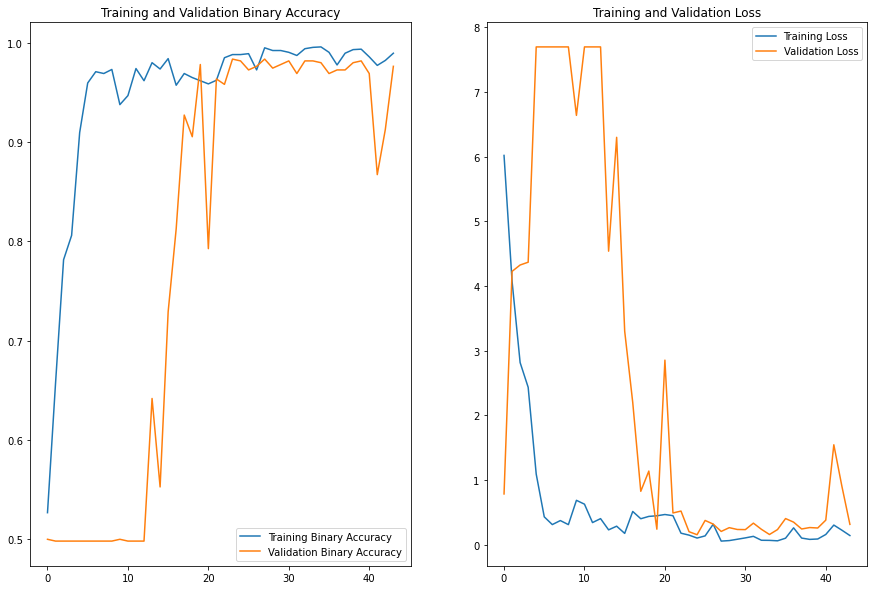

In [39]:
epochs_range = range(len(training_result3.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_result3.history['accuracy'], label='Training Binary Accuracy')
plt.plot(epochs_range, training_result3.history['val_accuracy'], label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Binary Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_result3.history['loss'], label='Training Loss')
plt.plot(epochs_range, training_result3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') 
plt.show()

In [42]:
print(net.summary())
print(net2.summary())
print(net3.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net (ResNet)            (None, 2)                 11180674  
                                                                 
Total params: 11,180,674
Trainable params: 11,172,866
Non-trainable params: 7,808
_________________________________________________________________
None
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_ince_net (ResInceNet)   (None, 2)                 5260994   
                                                                 
Total params: 5,260,994
Trainable params: 5,253,186
Non-trainable params: 7,808
_________________________________________________________________
None
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Outpu